# Baselines and their results

In [1]:
from gcn import *
from gcn_perturbation_matrix import *
import torch
import numpy as np
from sklearn.metrics import accuracy_score
from calculate_metrics import *
import pickle

/Users/janneke/opt/anaconda3/envs/CF-GNNExplainer/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('data/syn1.pickle','rb') as pickle_file: 
    data_syn1 = pickle.load(pickle_file)

with open('data/syn4.pickle','rb') as pickle_file:
    data_syn4 = pickle.load(pickle_file)
    
with open('data/syn5.pickle','rb') as pickle_file:
    data_syn5 = pickle.load(pickle_file)

In [3]:
# squeeze the labels (as it has a singleton dim and then make it a tensor)
labels_syn1 = np.squeeze(data_syn1['labels'])
labels_syn1 = torch.tensor(labels_syn1)

labels_syn4 = np.squeeze(data_syn4['labels'])
labels_syn4 = torch.tensor(labels_syn4)

labels_syn5 = np.squeeze(data_syn5['labels'])
labels_syn5 = torch.tensor(labels_syn5)

# same for features, but define the type of data here
features_syn1 = np.squeeze(data_syn1['feat'])
features_syn1 = torch.tensor(features_syn1, dtype=torch.float)

features_syn4 = np.squeeze(data_syn4['feat'])
features_syn4 = torch.tensor(features_syn4, dtype=torch.float)

features_syn5 = np.squeeze(data_syn5['feat'])
features_syn5 = torch.tensor(features_syn5, dtype=torch.float)

# adjacency matrix
adjacency_matrix_syn1 = torch.tensor(np.squeeze(data_syn1['adj']), dtype=torch.float)
adjacency_matrix_syn4 = torch.tensor(np.squeeze(data_syn4['adj']), dtype=torch.float)
adjacency_matrix_syn5 = torch.tensor(np.squeeze(data_syn5['adj']), dtype=torch.float)

# the indices are already a list --> but have to split the training data in training and validation data first
train_indices_full_syn1 = torch.tensor(data_syn1['train_idx'])
train_indices_full_syn4 = torch.tensor(data_syn4['train_idx'])
train_indices_full_syn5 = torch.tensor(data_syn5['train_idx'])

# split in training and validation indices
train_indices_syn1, validation_indices_syn1 = torch.utils.data.random_split(train_indices_full_syn1, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_indices_syn4, validation_indices_syn4 = torch.utils.data.random_split(train_indices_full_syn4, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_indices_syn5, validation_indices_syn5 = torch.utils.data.random_split(train_indices_full_syn5, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

test_indices_syn1 = torch.tensor(data_syn1['test_idx'])
test_indices_syn4 = torch.tensor(data_syn4['test_idx'])
test_indices_syn5 = torch.tensor(data_syn5['test_idx'])

In [4]:
model_syn1 = torch.load('models/syn1model.pt')
model_syn4 = torch.load('models/syn4model.pt')
model_syn5 = torch.load('models/syn5model.pt')

In [5]:
model_syn1.eval()
sparse_adj_1 = get_sparse_adjacency_normalized(features_syn1.shape[0], adjacency_matrix_syn1)
outputs_syn1 = model_syn1(features_syn1, sparse_adj_1)

# print accuracy too (to check that it is the same as in the original)
_, predictions_1 = torch.max(outputs_syn1.data, 1)
print("Test accuracy of Syn1 data: ", accuracy_score(labels_syn1[test_indices_syn1], predictions_1[test_indices_syn1]))

model_syn4.eval()
sparse_adj_4 = get_sparse_adjacency_normalized(features_syn4.shape[0], adjacency_matrix_syn4)
outputs_syn4 = model_syn4(features_syn4, sparse_adj_4)

# print accuracy too (to check that it is the same as in the original)
_, predictions_4 = torch.max(outputs_syn4.data, 1)
print("Test accuracy of Syn4 data: ", accuracy_score(labels_syn4[test_indices_syn4], predictions_4[test_indices_syn4]))

model_syn5.eval()
sparse_adj_5 = get_sparse_adjacency_normalized(features_syn5.shape[0], adjacency_matrix_syn5)
outputs_syn5 = model_syn5(features_syn5, sparse_adj_5)

# print accuracy too (to check that it is the same as in the original)
_, predictions_5 = torch.max(outputs_syn5.data, 1)
print("Test accuracy of Syn5 data: ", accuracy_score(labels_syn5[test_indices_syn5], predictions_5[test_indices_syn5]))

Test accuracy of Syn1 data:  0.9928571428571429
Test accuracy of Syn4 data:  0.9142857142857143
Test accuracy of Syn5 data:  0.8623481781376519


/Users/janneke/Documents/GitHub/CF-GNNExplainer-recreation/gcn.py:159: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525473998/work/torch/csrc/utils/tensor_new.cpp:233.)
  A_hat = torch.sparse_coo_tensor((A_hat.row, A_hat.col), A_hat.data, dtype=torch.float)


## Random baseline

Steps of the random baseline (according to the paper):
1. Randomly initialize P_hat in [-1,1]
2. Apply sigmoid and threshold
3. Do this for K times, keep minimal CF

In [6]:
def random_baseline(subgraph, k, model, old_prediction, feat, index):
    min_deleted = float('inf')
    perturbation_matrix = []
    
    for number in range(k):
        size_vector = int(subgraph.shape[0] * (subgraph.shape[0] + 1) / 2)
        
        p_hat = torch.FloatTensor(size_vector).uniform_(-1,1)
        pert = sigmoid(p_hat)
        pert = (pert > 0.5).float()

        # populate the matrix symmetrically
        index_row, index_col = torch.triu_indices(subgraph.shape[0], subgraph.shape[0])

        P = torch.zeros(subgraph.shape[0], subgraph.shape[0])
        P[index_row, index_col] = pert
        P.T[index_row, index_col] = pert
        
        # get the new matrix and how many edges were deleted in total
        new_matrix = torch.mul(subgraph, P)
        nr_deleted = torch.sum((new_matrix != subgraph).float()).data / 2
        
        # find new prediction:
        sparse_adj = get_sparse_adjacency_normalized(feat.shape[0], new_matrix)
        
        with torch.no_grad():
            outputs = model(feat, sparse_adj)
            
        _, predictions_test = torch.max(outputs.data, 1)
        new_prediction = predictions_test[index].item()
        
        if nr_deleted < min_deleted and new_prediction != old_prediction:
            perturbation_matrix.append(P)
    
    return perturbation_matrix

## 1-Hop baseline and remove 1-Hop baseline

Steps of the 1-Hop baseline (according to the paper):
1. Get ego-graph of node
2. Remove every edge not in the ego graph

Steps of the Remove 1-Hop baseline (according to the paper):
1. Get ego-graph of node
2. Remove every edge in the ego graph

In [7]:
def one_hop_baselines(subgraph, model, old_prediction, feat, node):
    # return both the perturbation matrix for the one-hop and remove one-hop baselines IF it is a explanation
    # in same format as before (list of tensors)
    perturbation_matrix_one_hop = [] 
    perturbation_matrix_remove_one_hop = [] 
    
    # collect all NODES that are one hop away - similar to how the neighbourhood was found before
    vertices = set([node])
    
    for vertex_1 in list(vertices):  # loop over all vertices already in the set --> this is the column we're in
        for vertex_2 in range(subgraph.shape[0]):  # loop over every incoming connection of a certain vertex - this is the row
            if subgraph[vertex_2, vertex_1] != 0:
                vertices.add(vertex_2)  # add the vertex if there is a connection
    
    vertex_list = list(vertices)
    vertex_list_not = [i for i in list(range(subgraph.shape[0])) if i not in vertex_list ]
    
    vertex_list = torch.tensor(vertex_list)
    vertex_list_not = torch.tensor(vertex_list_not)
    
    # for one hop: keep all these nodes --> zero out every other row/column    
    one_hop_pert = torch.ones(subgraph.shape[0], subgraph.shape[0])
    one_hop_pert[vertex_list_not, :] = 0
    one_hop_pert[:, vertex_list_not] = 0

    # for remove one hop: zero out these rows/columns, keep the rest
    one_hop_pert_rm = torch.ones(subgraph.shape[0], subgraph.shape[0])
    one_hop_pert_rm[vertex_list, :] = 0
    one_hop_pert_rm[:, vertex_list] = 0
    
    # perturb:
    one_hop_subgraph = torch.mul(subgraph, one_hop_pert)
    one_hop_subgraph_rm = torch.mul(subgraph, one_hop_pert_rm)
    
    # check whether it is counterfactual - one hop:
    sparse_adj_one_hop = get_sparse_adjacency_normalized(feat.shape[0], one_hop_subgraph)
        
    with torch.no_grad():
        outputs_one_hop = model(feat, sparse_adj_one_hop)
            
    _, predictions_test = torch.max(outputs_one_hop.data, 1)
    new_prediction_one_hop = predictions_test[node].item()
    
    # check whether it is counterfactual - one hop removed:
    sparse_adj_one_hop_rm = get_sparse_adjacency_normalized(feat.shape[0], one_hop_subgraph_rm)
        
    with torch.no_grad():
        outputs_one_hop_rm = model(feat, sparse_adj_one_hop_rm)
            
    _, predictions_test_rm = torch.max(outputs_one_hop_rm.data, 1)
    new_prediction_one_hop_rm = predictions_test_rm[node].item()
        
    # add to list if it is a counterexample
    
    if new_prediction_one_hop != old_prediction:
        perturbation_matrix_one_hop.append(one_hop_pert)
    
    if new_prediction_one_hop_rm != old_prediction:
        perturbation_matrix_remove_one_hop.append(one_hop_pert_rm)
    
    return perturbation_matrix_one_hop, perturbation_matrix_remove_one_hop

## Run all the baselines:

### Syn 1:

In [8]:
torch.manual_seed(42)
np.random.seed(42)

examples_all_random_syn1 = []
examples_all_one_hop_syn1 = []
examples_all_one_hop_rm_syn1 = []

adjacency_neigh_syn1 = []
mapping_syn1 = []

nr_cf_syn1_rand = 0
nr_cf_syn1_one_hop = 0
nr_cf_syn1_one_hop_rm = 0

k = 500

for index in test_indices_syn1: 
    old_prediction = predictions_1[index.item()]
    
    # get the subgraph neighbourhood
    adjacency_matrix, vertex_mapping, labels_perturbed, features_perturbed = create_subgraph_neighbourhood2(index.item(), 4, labels_syn1, features_syn1, adjacency_matrix_syn1)
    
    new_index = vertex_mapping[index.item()]
    
    # for random
    perturbation_random = random_baseline(adjacency_matrix, k, model_syn1, old_prediction, features_perturbed, new_index)
    
    # for one hop and remove one hop:
    one_hop_pert, remove_one_hop_pert =  one_hop_baselines(adjacency_matrix, model_syn1, old_prediction, features_perturbed, new_index)
    
    # put all the ones here:
    examples_all_random_syn1.append(perturbation_random)
    # add 1-hop
    examples_all_one_hop_syn1.append(one_hop_pert)
    # add remove 1-hop
    examples_all_one_hop_rm_syn1.append(remove_one_hop_pert)
    # add gnnexplainer
    
    
    adjacency_neigh_syn1.append(adjacency_matrix)
    mapping_syn1.append(vertex_mapping)
    
    if perturbation_random != []:
        nr_cf_syn1_rand+= 1
    if one_hop_pert != []:
        nr_cf_syn1_one_hop += 1
    if remove_one_hop_pert != []:  
        nr_cf_syn1_one_hop_rm += 1

In [9]:
# for random baseline
sparsity_mean_random, sparsity_std_random = sparsity(adjacency_neigh_syn1, examples_all_random_syn1)
fidelity_syn1_random = fidelity(len(test_indices_syn1), nr_cf_syn1_rand)
accuracy_edges_syn1_random, accuracy_edges_syn1_std_random, accuracy_vertices_syn1_random, accuracy_vertices_syn1_std_random = accuracy_explanation(test_indices_syn1, predictions_1, adjacency_neigh_syn1, examples_all_random_syn1, mapping_syn1)
explanation_size_mean_random, explanation_size_std_random, explanation_size_list_syn1_random = explanation_size(examples_all_random_syn1, adjacency_neigh_syn1)

# for one hop baseline
sparsity_mean_oh, sparsity_std_oh = sparsity(adjacency_neigh_syn1, examples_all_one_hop_syn1)
fidelity_syn1_oh = fidelity(len(test_indices_syn1), nr_cf_syn1_one_hop)
accuracy_edges_syn1_oh, accuracy_edges_syn1_std_oh, accuracy_vertices_syn1_oh, accuracy_vertices_syn1_std_oh = accuracy_explanation(test_indices_syn1, predictions_1, adjacency_neigh_syn1, examples_all_one_hop_syn1, mapping_syn1)
explanation_size_mean_oh, explanation_size_std_oh, explanation_size_list_syn1_oh = explanation_size(examples_all_one_hop_syn1, adjacency_neigh_syn1)

# for one hop rm baseline
sparsity_mean_oh_rm, sparsity_std_oh_rm = sparsity(adjacency_neigh_syn1, examples_all_one_hop_rm_syn1)
fidelity_syn1_oh_rm = fidelity(len(test_indices_syn1), nr_cf_syn1_one_hop_rm)
accuracy_edges_syn1_oh_rm, accuracy_edges_syn1_std_oh_rm, accuracy_vertices_syn1_oh_rm, accuracy_vertices_syn1_std_oh_rm = accuracy_explanation(test_indices_syn1, predictions_1, adjacency_neigh_syn1, examples_all_one_hop_rm_syn1, mapping_syn1)
explanation_size_mean_oh_rm, explanation_size_std_oh_rm, explanation_size_list_syn1_oh_rm = explanation_size(examples_all_one_hop_rm_syn1, adjacency_neigh_syn1)


print("Syn1 Random Baseline, fidelity:", fidelity_syn1_random)
print("Syn1 Random Baseline, mean sparsity:", sparsity_mean_random)
print("Syn1 Random Baseline, mean accuracy (edges):", accuracy_edges_syn1_random)
print("Syn1 Random Baseline, mean accuracy (vertices):", accuracy_vertices_syn1_random)
print("Syn1 Random Baseline, mean explanation size:", explanation_size_mean_random)
print()
print("Syn1 Random Baseline, std sparsity:", sparsity_std_random)
print("Syn1 Random Baseline, std accuracy (edges):", accuracy_edges_syn1_std_random)
print("Syn1 Random Baseline, std accuracy (vertices):", accuracy_vertices_syn1_std_random)
print("Syn1 Random Baseline, std explanation size:", explanation_size_std_random)
print("------")
print("Syn1 One-Hop Baseline, fidelity:", fidelity_syn1_oh)
print("Syn1 One-Hop Baseline, mean sparsity:", sparsity_mean_oh)
print("Syn1 One-Hop Baseline, mean accuracy (edges):", accuracy_edges_syn1_oh)
print("Syn1 One-Hop Baseline, mean accuracy (vertices):", accuracy_vertices_syn1_oh)
print("Syn1 One-Hop Baseline, mean explanation size:", explanation_size_mean_oh)
print()
print("Syn1 One-Hop Baseline, std sparsity:", sparsity_std_oh)
print("Syn1 One-Hop Baseline, std accuracy (edges):", accuracy_edges_syn1_std_oh)
print("Syn1 One-Hop Baseline, std accuracy (vertices):", accuracy_vertices_syn1_std_oh)
print("Syn1 One-Hop Baseline, std explanation size:", explanation_size_std_oh)
print("------")
print("Syn1 RM One-Hop Baseline, fidelity:", fidelity_syn1_oh_rm)
print("Syn1 RM One-Hop Baseline, mean sparsity:", sparsity_mean_oh_rm)
print("Syn1 RM One-Hop Baseline, mean accuracy (edges):", accuracy_edges_syn1_oh_rm)
print("Syn1 RM One-Hop Baseline, mean accuracy (vertices):", accuracy_vertices_syn1_oh_rm)
print("Syn1 RM One-Hop Baseline, mean explanation size:", explanation_size_mean_oh_rm)
print()
print("Syn1 RM One-Hop Baseline, std sparsity:", sparsity_std_oh_rm)
print("Syn1 RM One-Hop Baseline, std accuracy (edges):", accuracy_edges_syn1_std_oh_rm)
print("Syn1 RM One-Hop Baseline, std accuracy (vertices):", accuracy_vertices_syn1_std_oh_rm)
print("Syn1 RM One-Hop Baseline, std explanation size:", explanation_size_std_oh_rm)

Syn1 Random Baseline, fidelity: 0.0357142857142857
Syn1 Random Baseline, mean sparsity: 0.49437295286743727
Syn1 Random Baseline, mean accuracy (edges): 0.11164855654435205
Syn1 Random Baseline, mean accuracy (vertices): 0.16715958400672418
Syn1 Random Baseline, mean explanation size: 539.3185185185185

Syn1 Random Baseline, std sparsity: 0.03701965533803113
Syn1 Random Baseline, std accuracy (edges): 0.17793256716580058
Syn1 Random Baseline, std accuracy (vertices): 0.16678640893795382
Syn1 Random Baseline, std explanation size: 348.3060211308409
------
Syn1 One-Hop Baseline, fidelity: 0.6
Syn1 One-Hop Baseline, mean sparsity: 0.04522536907877241
Syn1 One-Hop Baseline, mean accuracy (edges): 0.1196297291228887
Syn1 One-Hop Baseline, mean accuracy (vertices): 0.1795571760388576
Syn1 One-Hop Baseline, mean explanation size: 504.17857142857144

Syn1 One-Hop Baseline, std sparsity: 0.054456078250878344
Syn1 One-Hop Baseline, std accuracy (edges): 0.1367061141039948
Syn1 One-Hop Baseline, 

### Syn 4:

In [10]:
torch.manual_seed(42)
np.random.seed(42)

examples_all_random_syn4 = []
examples_all_one_hop_syn4 = []
examples_all_one_hop_rm_syn4 = []

adjacency_neigh_syn4 = []
mapping_syn4 = []

nr_cf_syn4_rand = 0
nr_cf_syn4_one_hop = 0
nr_cf_syn4_one_hop_rm = 0

k = 500

for index in test_indices_syn4: 
    old_prediction = predictions_4[index.item()]
    
    # get the subgraph neighbourhood
    adjacency_matrix, vertex_mapping, labels_perturbed, features_perturbed = create_subgraph_neighbourhood2(index.item(), 4, labels_syn4, features_syn4, adjacency_matrix_syn4)
    
    new_index = vertex_mapping[index.item()]
    
    # for random
    perturbation_random = random_baseline(adjacency_matrix, k, model_syn4, old_prediction, features_perturbed, new_index)
    
    # for one hop and remove one hop:
    one_hop_pert, remove_one_hop_pert =  one_hop_baselines(adjacency_matrix, model_syn4, old_prediction, features_perturbed, new_index)
    
    # put all the ones here:
    examples_all_random_syn4.append(perturbation_random)
    # add 1-hop
    examples_all_one_hop_syn4.append(one_hop_pert)
    # add remove 1-hop
    examples_all_one_hop_rm_syn4.append(remove_one_hop_pert)
    # add gnnexplainer
    
    
    adjacency_neigh_syn4.append(adjacency_matrix)
    mapping_syn4.append(vertex_mapping)
    
    if perturbation_random != []:
        nr_cf_syn4_rand+= 1
    if one_hop_pert != []:
        nr_cf_syn4_one_hop += 1
    if remove_one_hop_pert != []:  
        nr_cf_syn4_one_hop_rm += 1

In [11]:
# for random baseline
sparsity_mean_random, sparsity_std_random = sparsity(adjacency_neigh_syn4, examples_all_random_syn4)
fidelity_syn4_random = fidelity(len(test_indices_syn4), nr_cf_syn4_rand)
accuracy_edges_syn4_random, accuracy_edges_syn4_std_random, accuracy_vertices_syn4_random, accuracy_vertices_syn4_std_random = accuracy_explanation(test_indices_syn4, predictions_4, adjacency_neigh_syn4, examples_all_random_syn4, mapping_syn4)
explanation_size_mean_random, explanation_size_std_random, explanation_size_list_syn4_random = explanation_size(examples_all_random_syn4, adjacency_neigh_syn4)

# for one hop baseline
sparsity_mean_oh, sparsity_std_oh = sparsity(adjacency_neigh_syn4, examples_all_one_hop_syn4)
fidelity_syn4_oh = fidelity(len(test_indices_syn4), nr_cf_syn4_one_hop)
accuracy_edges_syn4_oh, accuracy_edges_syn4_std_oh, accuracy_vertices_syn4_oh, accuracy_vertices_syn4_std_oh = accuracy_explanation(test_indices_syn4, predictions_4, adjacency_neigh_syn4, examples_all_one_hop_syn4, mapping_syn4)
explanation_size_mean_oh, explanation_size_std_oh, explanation_size_list_syn4_oh = explanation_size(examples_all_one_hop_syn4, adjacency_neigh_syn4)

# for one hop rm baseline
sparsity_mean_oh_rm, sparsity_std_oh_rm = sparsity(adjacency_neigh_syn4, examples_all_one_hop_rm_syn4)
fidelity_syn4_oh_rm = fidelity(len(test_indices_syn4), nr_cf_syn4_one_hop_rm)
accuracy_edges_syn4_oh_rm, accuracy_edges_syn4_std_oh_rm, accuracy_vertices_syn4_oh_rm, accuracy_vertices_syn4_std_oh_rm= accuracy_explanation(test_indices_syn4, predictions_4, adjacency_neigh_syn4, examples_all_one_hop_rm_syn4, mapping_syn4)
explanation_size_mean_oh_rm, explanation_size_std_oh_rm, explanation_size_list_syn4_oh_rm = explanation_size(examples_all_one_hop_rm_syn4, adjacency_neigh_syn4)


print("Syn4 Random Baseline, fidelity:", fidelity_syn4_random)
print("Syn4 Random Baseline, mean sparsity:", sparsity_mean_random)
print("Syn4 Random Baseline, mean accuracy (edges):", accuracy_edges_syn4_random)
print("Syn4 Random Baseline, mean accuracy (vertices):", accuracy_vertices_syn4_random)
print("Syn4 Random Baseline, mean explanation size:", explanation_size_mean_random)
print()
print("Syn4 Random Baseline, std sparsity:", sparsity_std_random)
print("Syn4 Random Baseline, std accuracy (edges):", accuracy_edges_syn4_std_random)
print("Syn4 Random Baseline, std accuracy (vertices):", accuracy_vertices_syn4_std_random)
print("Syn4 Random Baseline, std explanation size:", explanation_size_std_random)
print("------")
print("Syn4 One-Hop Baseline, fidelity:", fidelity_syn4_oh)
print("Syn4 One-Hop Baseline, mean sparsity:", sparsity_mean_oh)
print("Syn4 One-Hop Baseline, mean accuracy (edges):", accuracy_edges_syn4_oh)
print("Syn4 One-Hop Baseline, mean accuracy (vertices):", accuracy_vertices_syn4_oh)
print("Syn4 One-Hop Baseline, mean explanation size:", explanation_size_mean_oh)
print()
print("Syn4 One-Hop Baseline, std sparsity:", sparsity_std_oh)
print("Syn4 One-Hop Baseline, std accuracy (edges):", accuracy_edges_syn4_std_oh)
print("Syn4 One-Hop Baseline, std accuracy (vertices):", accuracy_vertices_syn4_std_oh)
print("Syn4 One-Hop Baseline, std explanation size:", explanation_size_std_oh)
print("------")
print("Syn4 RM One-Hop Baseline, fidelity:", fidelity_syn4_oh_rm)
print("Syn4 RM One-Hop Baseline, mean sparsity:", sparsity_mean_oh_rm)
print("Syn4 RM One-Hop Baseline, mean accuracy (edges):", accuracy_edges_syn4_oh_rm)
print("Syn4 RM One-Hop Baseline, mean accuracy (vertices):", accuracy_vertices_syn4_oh_rm)
print("Syn4 RM One-Hop Baseline, mean explanation size:", explanation_size_mean_oh_rm)
print()
print("Syn4 RM One-Hop Baseline, std sparsity:", sparsity_std_oh_rm)
print("Syn4 RM One-Hop Baseline, std accuracy (edges):", accuracy_edges_syn4_std_oh_rm)
print("Syn4 RM One-Hop Baseline, std accuracy (vertices):", accuracy_vertices_syn4_std_oh_rm)
print("Syn4 RM One-Hop Baseline, std explanation size:", explanation_size_std_oh_rm)

Syn4 Random Baseline, fidelity: 0.0
Syn4 Random Baseline, mean sparsity: 0.48675720844949993
Syn4 Random Baseline, mean accuracy (edges): 0.4240919515811515
Syn4 Random Baseline, mean accuracy (vertices): 0.5174686012114494
Syn4 Random Baseline, mean explanation size: 10.291428571428572

Syn4 Random Baseline, std sparsity: 0.11971815721733024
Syn4 Random Baseline, std accuracy (edges): 0.22975766872696637
Syn4 Random Baseline, std accuracy (vertices): 0.20203379218379433
Syn4 Random Baseline, std explanation size: 6.84312606812387
------
Syn4 One-Hop Baseline, fidelity: 0.3028571428571428
Syn4 One-Hop Baseline, mean sparsity: 0.13260503528548068
Syn4 One-Hop Baseline, mean accuracy (edges): 0.38262139919599114
Syn4 One-Hop Baseline, mean accuracy (vertices): 0.4745916525320995
Syn4 One-Hop Baseline, mean explanation size: 15.614754098360656

Syn4 One-Hop Baseline, std sparsity: 0.06326750532023097
Syn4 One-Hop Baseline, std accuracy (edges): 0.2048744683443888
Syn4 One-Hop Baseline, st

### Syn5:

In [12]:
torch.manual_seed(42)
np.random.seed(42)

examples_all_random_syn5 = []
examples_all_one_hop_syn5 = []
examples_all_one_hop_rm_syn5 = []

adjacency_neigh_syn5 = []
mapping_syn5 = []

nr_cf_syn5_rand = 0
nr_cf_syn5_one_hop = 0
nr_cf_syn5_one_hop_rm = 0

k = 500

for index in test_indices_syn5: 
    old_prediction = predictions_5[index.item()]
    
    # get the subgraph neighbourhood
    adjacency_matrix, vertex_mapping, labels_perturbed, features_perturbed = create_subgraph_neighbourhood2(index.item(), 4, labels_syn5, features_syn5, adjacency_matrix_syn5)
    
    new_index = vertex_mapping[index.item()]
    
    # for random
    perturbation_random = random_baseline(adjacency_matrix, k, model_syn5, old_prediction, features_perturbed, new_index)
    
    # for one hop and remove one hop:
    one_hop_pert, remove_one_hop_pert =  one_hop_baselines(adjacency_matrix, model_syn5, old_prediction, features_perturbed, new_index)
    
    # put all the ones here:
    examples_all_random_syn5.append(perturbation_random)
    # add 1-hop
    examples_all_one_hop_syn5.append(one_hop_pert)
    # add remove 1-hop
    examples_all_one_hop_rm_syn5.append(remove_one_hop_pert)
    # add gnnexplainer
    
    
    adjacency_neigh_syn5.append(adjacency_matrix)
    mapping_syn5.append(vertex_mapping)
    
    if perturbation_random != []:
        nr_cf_syn5_rand+= 1
    if one_hop_pert != []:
        nr_cf_syn5_one_hop += 1
    if remove_one_hop_pert != []:  
        nr_cf_syn5_one_hop_rm += 1

In [13]:
# for random baseline
sparsity_mean_random, sparsity_std_random = sparsity(adjacency_neigh_syn5, examples_all_random_syn5)
fidelity_syn5_random = fidelity(len(test_indices_syn5), nr_cf_syn5_rand)
accuracy_edges_syn5_random, accuracy_edges_syn5_std_random, accuracy_vertices_syn5_random, accuracy_vertices_syn5_std_random = accuracy_explanation(test_indices_syn5, predictions_5, adjacency_neigh_syn5, examples_all_random_syn5, mapping_syn5)
explanation_size_mean_random, explanation_size_std_random, explanation_size_list_syn5_random = explanation_size(examples_all_random_syn5, adjacency_neigh_syn5)

# for one hop baseline
sparsity_mean_oh, sparsity_std_oh = sparsity(adjacency_neigh_syn5, examples_all_one_hop_syn5)
fidelity_syn5_oh = fidelity(len(test_indices_syn5), nr_cf_syn5_one_hop)
accuracy_edges_syn5_oh, accuracy_edges_syn5_std_oh, accuracy_vertices_syn5_oh, accuracy_vertices_syn5_std_oh = accuracy_explanation(test_indices_syn5, predictions_5, adjacency_neigh_syn5, examples_all_one_hop_syn5, mapping_syn5)
explanation_size_mean_oh, explanation_size_std_oh, explanation_size_list_syn5_oh = explanation_size(examples_all_one_hop_syn5, adjacency_neigh_syn5)

# for one hop rm baseline
sparsity_mean_oh_rm, sparsity_std_oh_rm = sparsity(adjacency_neigh_syn5, examples_all_one_hop_rm_syn5)
fidelity_syn5_oh_rm = fidelity(len(test_indices_syn5), nr_cf_syn5_one_hop_rm)
accuracy_edges_syn5_oh_rm, accuracy_edges_syn5_std_oh_rm, accuracy_vertices_syn5_oh_rm, accuracy_vertices_syn5_std_oh_rm = accuracy_explanation(test_indices_syn5, predictions_5, adjacency_neigh_syn5, examples_all_one_hop_rm_syn5, mapping_syn5)
explanation_size_mean_oh_rm, explanation_size_std_oh_rm, explanation_size_list_syn5_oh_rm = explanation_size(examples_all_one_hop_rm_syn5, adjacency_neigh_syn5)


print("Syn5 Random Baseline, fidelity:", fidelity_syn5_random)
print("Syn5 Random Baseline, mean sparsity:", sparsity_mean_random)
print("Syn5 Random Baseline, mean accuracy (edges):", accuracy_edges_syn5_random)
print("Syn5 Random Baseline, mean accuracy (vertices):", accuracy_vertices_syn5_random)
print("Syn5 Random Baseline, mean explanation size:", explanation_size_mean_random)
print()
print("Syn5 Random Baseline, std sparsity:", sparsity_std_random)
print("Syn5 Random Baseline, std accuracy (edges):", accuracy_edges_syn5_std_random)
print("Syn5 Random Baseline, std accuracy (vertices):", accuracy_vertices_syn5_std_random)
print("Syn5 Random Baseline, std explanation size:", explanation_size_std_random)
print("------")
print("Syn5 One-Hop Baseline, fidelity:", fidelity_syn5_oh)
print("Syn5 One-Hop Baseline, mean sparsity:", sparsity_mean_oh)
print("Syn5 One-Hop Baseline, mean accuracy (edges):", accuracy_edges_syn5_oh)
print("Syn5 One-Hop Baseline, mean accuracy (vertices):", accuracy_vertices_syn5_oh)
print("Syn5 One-Hop Baseline, mean explanation size:", explanation_size_mean_oh)
print()
print("Syn5 One-Hop Baseline, std sparsity:", sparsity_std_oh)
print("Syn5 One-Hop Baseline, std accuracy (edges):", accuracy_edges_syn5_std_oh)
print("Syn5 One-Hop Baseline, std accuracy (edges):", accuracy_edges_syn5_std_oh)
print("Syn5 One-Hop Baseline, std explanation size:", explanation_size_std_oh)
print("------")
print("Syn5 RM One-Hop Baseline, fidelity:", fidelity_syn5_oh_rm)
print("Syn5 RM One-Hop Baseline, mean sparsity:", sparsity_mean_oh_rm)
print("Syn5 RM One-Hop Baseline, mean accuracy (edges):", accuracy_edges_syn5_oh_rm)
print("Syn5 RM One-Hop Baseline, mean accuracy (vertices):", accuracy_vertices_syn5_oh_rm)
print("Syn5 RM One-Hop Baseline, mean explanation size:", explanation_size_mean_oh_rm)
print()
print("Syn5 RM One-Hop Baseline, std sparsity:", sparsity_std_oh_rm)
print("Syn5 RM One-Hop Baseline, std accuracy (edges):", accuracy_edges_syn5_std_oh_rm)
print("Syn5 RM One-Hop Baseline, std accuracy (vertices):", accuracy_vertices_syn5_std_oh_rm)
print("Syn5 RM One-Hop Baseline, std explanation size:", explanation_size_std_oh_rm)

Syn5 Random Baseline, fidelity: 0.0
Syn5 Random Baseline, mean sparsity: 0.5060110597716652
Syn5 Random Baseline, mean accuracy (edges): 0.7707356954305508
Syn5 Random Baseline, mean accuracy (vertices): 0.8214586218230517
Syn5 Random Baseline, mean explanation size: 16.246963562753038

Syn5 Random Baseline, std sparsity: 0.08771627031170898
Syn5 Random Baseline, std accuracy (edges): 0.17614896363595964
Syn5 Random Baseline, std accuracy (vertices): 0.13475143657123248
Syn5 Random Baseline, std explanation size: 9.322133645358178
------
Syn5 One-Hop Baseline, fidelity: 0.17004048582995956
Syn5 One-Hop Baseline, mean sparsity: 0.09371247146187758
Syn5 One-Hop Baseline, mean accuracy (edges): 0.7456256685645382
Syn5 One-Hop Baseline, mean accuracy (vertices): 0.7798617524389853
Syn5 One-Hop Baseline, mean explanation size: 28.497560975609755

Syn5 One-Hop Baseline, std sparsity: 0.039526597112366946
Syn5 One-Hop Baseline, std accuracy (edges): 0.17253932862339663
Syn5 One-Hop Baseline, 

## Draw graphs for baselines

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

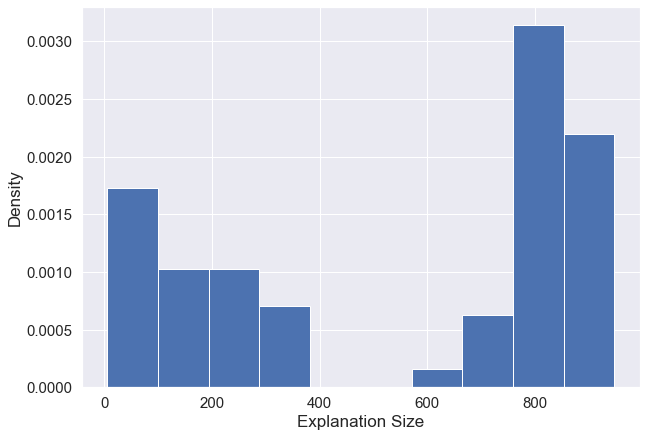

In [15]:
sns.set()

plt.hist(explanation_size_list_syn1_random, density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn1_random_baseline.png', dpi=100)
plt.show()

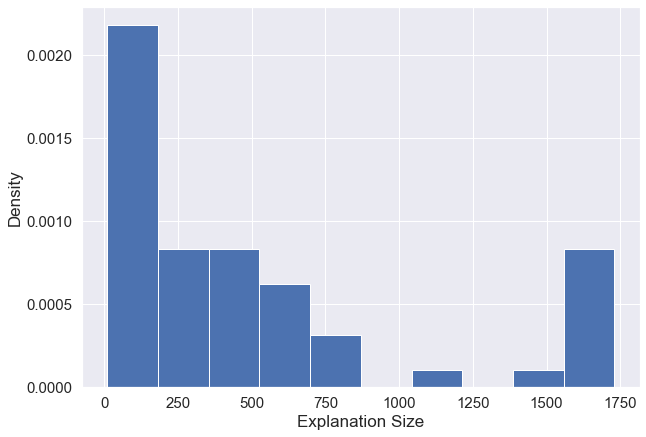

In [16]:
sns.set()

plt.hist(explanation_size_list_syn1_oh, density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn1_onehop_baseline.png', dpi=100)
plt.show()

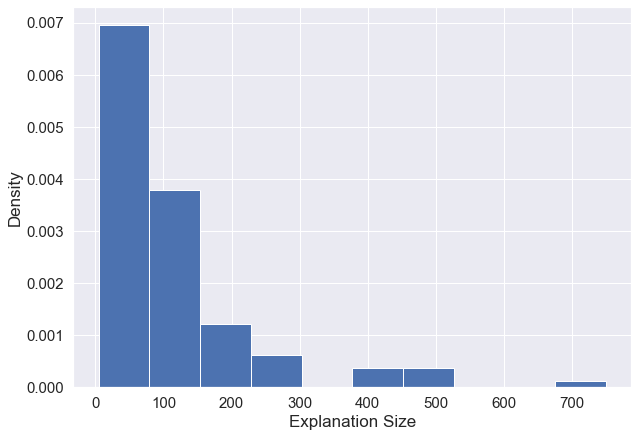

In [17]:
sns.set()

plt.hist(explanation_size_list_syn1_oh_rm, density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn1_rm_onehop_baseline.png', dpi=100)
plt.show()

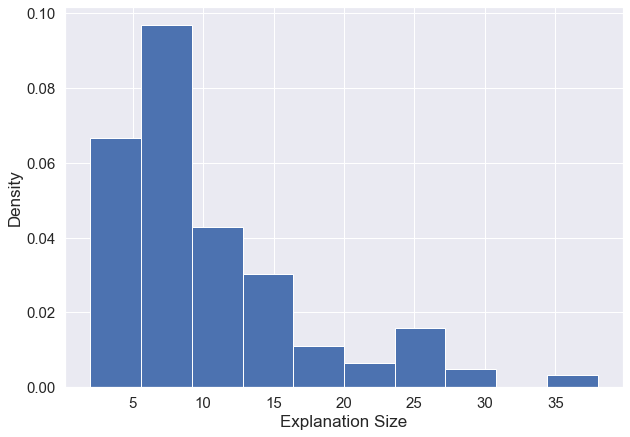

In [18]:
sns.set()

plt.hist(explanation_size_list_syn4_random, density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn4_random_baseline.png', dpi=100)
plt.show()

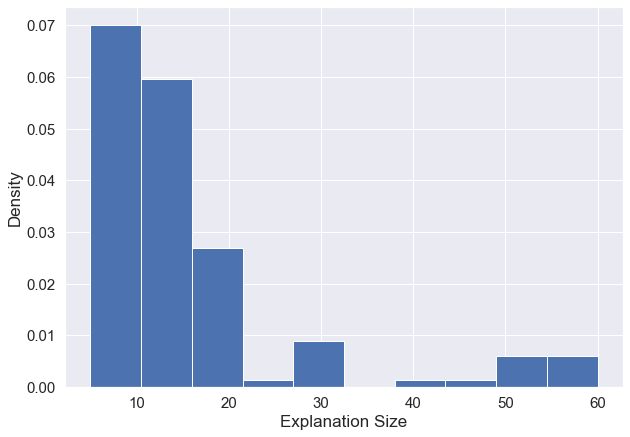

In [19]:
sns.set()

plt.hist(explanation_size_list_syn4_oh, density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn4_onehop_baseline.png', dpi=100)
plt.show()

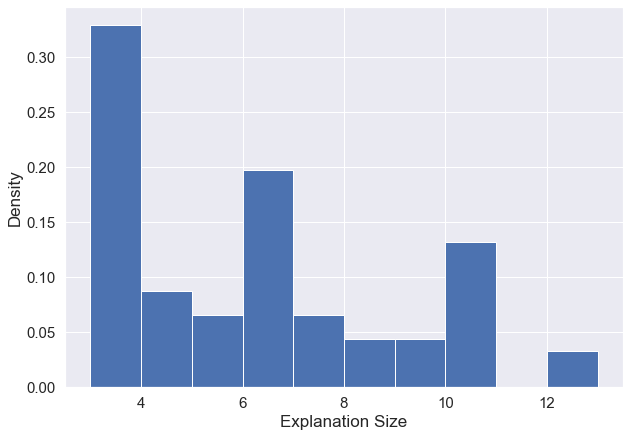

In [20]:
sns.set()

plt.hist(explanation_size_list_syn4_oh_rm, density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn4_rm_onehop_baseline.png', dpi=100)
plt.show()

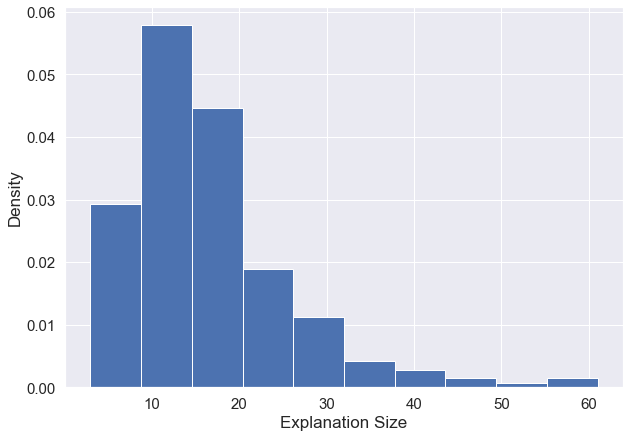

In [21]:
sns.set()

plt.hist(explanation_size_list_syn5_random, density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn5_random_baseline.png', dpi=100)
plt.show()

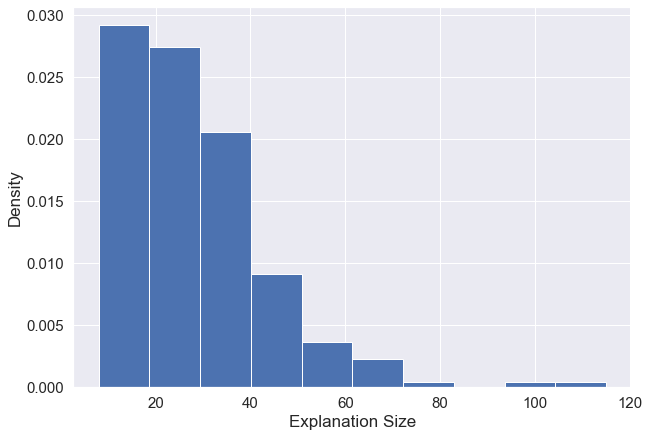

In [22]:
sns.set()

plt.hist(explanation_size_list_syn5_oh, density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn5_onehop_baseline.png', dpi=100)
plt.show()

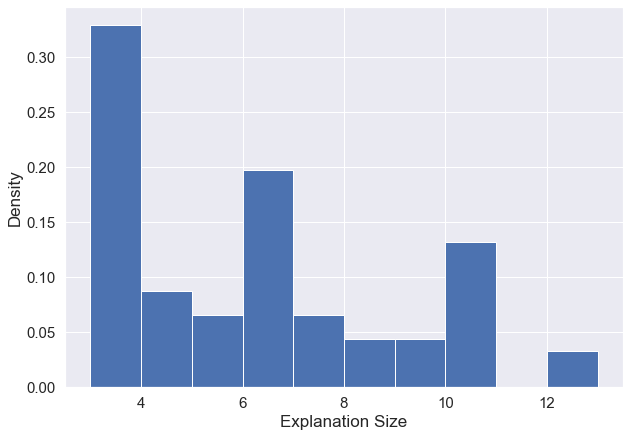

In [23]:
sns.set()

plt.hist(explanation_size_list_syn4_oh_rm, density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn5_rm_onehop_baseline.png', dpi=100)
plt.show()